In [1]:
from spatialSSL.Dataloader import EgoNetDataloader, FullImageConstracter
from spatialSSL.Utils import split_dataset
from spatialSSL.Training import train
from spatialSSL.Testing import test
from spatialSSL.Dataset import InMemoryGraphDataset
import numpy as np

C:\Users\lg\anaconda3\envs\spatial_atlas_ssl\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\lg\anaconda3\envs\spatial_atlas_ssl\lib\site-packages\spatialdata\__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [2]:
'''
import os
import scanpy as sc

adata = sc.read("./data/atlas_brain_638850_CCF.h5ad")
# subset the adata
selected_img = np.unique(adata.obs["section"])[0:20]
sub_adata = adata[adata.obs["section"].isin(selected_img)].copy()

# specify the output directory and file
output_dir = './data'
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, 'sub_20img_adata.h5ad')

# write the sub_adata into a .h5ad file
sub_adata.write(output_file)
'''

'\nimport os\nimport scanpy as sc\n\nadata = sc.read("./data/atlas_brain_638850_CCF.h5ad")\n# subset the adata\nselected_img = np.unique(adata.obs["section"])[0:20]\nsub_adata = adata[adata.obs["section"].isin(selected_img)].copy()\n\n# specify the output directory and file\noutput_dir = \'./data\'\nos.makedirs(output_dir, exist_ok=True)\noutput_file = os.path.join(output_dir, \'sub_20img_adata.h5ad\')\n\n# write the sub_adata into a .h5ad file\nsub_adata.write(output_file)\n'

In [3]:
# Create an instance of Full_image_dataloader

 
#file_path = "./data/img_119670929.h5ad"
file_path = "./data/subset_6img_atlas_brain.h5ad"
#file_path = "./data/atlas_brain_638850_CCF.h5ad"
#file_path = "./data/sub_20img_adata.h5ad"

data_constracter = FullImageConstracter(file_path=file_path,
                                        image_col="section",
                                        label_col="class_label",
                                        include_label=False,
                                        radius=20,
                                        node_level = 1,
                                        batch_size=1,
                                       mask_method = "cell_type",
                                       celltype_to_mask = "LQ")


In [4]:
# Load the data
data_constracter.load_data()

In [5]:
# Construct the graph
graph_list = data_constracter.construct_graph()

Constructing Graphs:   0%|          | 0/6 [00:00<?, ?it/s]

In [6]:
len(graph_list)

6

In [7]:
train_loader, val_loader, test_loader = split_dataset(graph_list,split_percent=(0.6, 0.2, 0.2), batch_size=2)

In [8]:
train_loader

In [9]:
for x in train_loader:
    print(x.cell_type_masked)
    print(x)
    break

[['LQ', 'LQ', 'LQ', 'LQ', 'LQ', ..., 'LQ', 'LQ', 'LQ', 'LQ', 'LQ']
Length: 16
Categories (18, object): ['Astro-Epen', 'CB GABA', 'CB Glut', 'CNU GABA', ..., 'Oligo', 'P GABA', 'P Glut', 'Vascular'], ['LQ', 'LQ', 'LQ', 'LQ', 'LQ', ..., 'LQ', 'LQ', 'LQ', 'LQ', 'LQ']
Length: 15
Categories (21, object): ['Astro-Epen', 'CB GABA', 'CB Glut', 'CNU-HYa GABA', ..., 'P GABA', 'P Glut', 'TH Glut', 'Vascular']]
DataBatch(x=[86942, 550], edge_index=[2, 292900], y=[31, 550], mask=[86942], cell_type=[2], cell_type_masked=[2], image=[2], batch=[86942], ptr=[3])


In [10]:
# Print out the size of each set to verify
print(f"Train size: {len(train_loader.dataset)}")
print(f"Validation size: {len(val_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")

Train size: 3
Validation size: 1
Test size: 2


In [11]:
from torch import nn, optim, Tensor
import torch
from torch_geometric.nn import GCNConv,GATConv
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import r2_score
from torch.nn import LeakyReLU, Dropout
import time

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)
        self.dropout = Dropout(dropout_rate)
        
        self.act = nn.LeakyReLU()

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.dropout(self.act(self.conv1(x, edge_index)))
        x = self.dropout(self.act(self.conv2(x, edge_index)))
        x = self.dropout(self.act(self.conv3(x, edge_index)))
        x = self.act(self.conv4(x, edge_index))  # Typically, dropout is not applied to the final layer.
        return x

class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)
        self.dropout = Dropout(dropout_rate)
        
        self.act = nn.LeakyReLU()

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.dropout(self.act(self.conv1(x, edge_index)))
        x = self.dropout(self.act(self.conv2(x, edge_index)))
        x = self.dropout(self.act(self.conv3(x, edge_index)))
        x = self.act(self.conv4(x, edge_index))  # Typically, dropout is not applied to the final layer.
        return x
    
class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, out_channels)
        self.conv4 = GATConv(hidden_channels, out_channels)
        self.dropout = Dropout(dropout_rate)
        self.act = nn.LeakyReLU()

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.dropout(self.act(self.conv1(x, edge_index)))
        x = self.dropout(self.act(self.conv2(x, edge_index)))
        x = self.dropout(self.act(self.conv3(x, edge_index)))
        x = self.act(self.conv4(x, edge_index))  # Typically, dropout is not applied to the final layer.
        return x

In [12]:

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the model
model = GAT(550, 550, 550).to(device) # in_channels is set to 100 as an example. Please replace it with your actual feature size.

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
#scheduler = StepLR(optimizer, step_size=80, gamma=0.1) # learning rate scheduler

num_epochs = 1
patience = 8


train(model, train_loader, val_loader,optimizer, criterion, num_epochs, patience, model_name = './models/model.pt')


Epoch 1/1, train loss: 0.8638, train r2: -1.2627,  val loss: 0.8098, val r2: -0.8735, Time: 28.80947709083557s
Best val loss: 0.8098, at epoch 1


In [13]:
test_loss, test_r2,test_targets_list,test_outputs_list,test_celltypes_list = test(model, test_loader, criterion, device)

  0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.8423, test r2: -0.6628


In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# usage
model = GAT(550, 550, 550)  # Replace with your actual model
print(f'The model has {count_parameters(model):,} parameters')


The model has 1,216,600 parameters


In [15]:
# Flatten the nested list into a single-dimensional list
flattened_list = [item for sublist in np.concatenate(test_celltypes_list) for item in sublist]

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [16]:
import pandas as pd

preds_test_per_cell = pd.DataFrame({'celltype': flattened_list, 'r2_score': r2_score(np.transpose(torch.cat(test_targets_list).cpu().detach().numpy()), np.transpose(torch.cat(test_outputs_list).cpu().detach().numpy()), multioutput='raw_values')})

preds_test_per_gene = pd.DataFrame({'gene': data_constracter.adata.var_names, 'r2_score': r2_score(torch.cat(test_targets_list).cpu().detach().numpy(), torch.cat(test_outputs_list).cpu().detach().numpy(), multioutput='raw_values')})



In [17]:
preds_test_per_gene

,gene,r2_score
0,Prkcq,-2.461888
1,Col5a1,-0.211288
2,Grik3,-0.383526
3,Igfbp2,-0.243282
4,Osr1,-0.090769
...,...,...
545,Blank-33,0.000000
546,Blank-34,0.000000
547,Blank-45,0.000000
548,Blank-23,0.000000


In [17]:
# huge class inbalance problem, need to handel -> add weight?
# add pooling

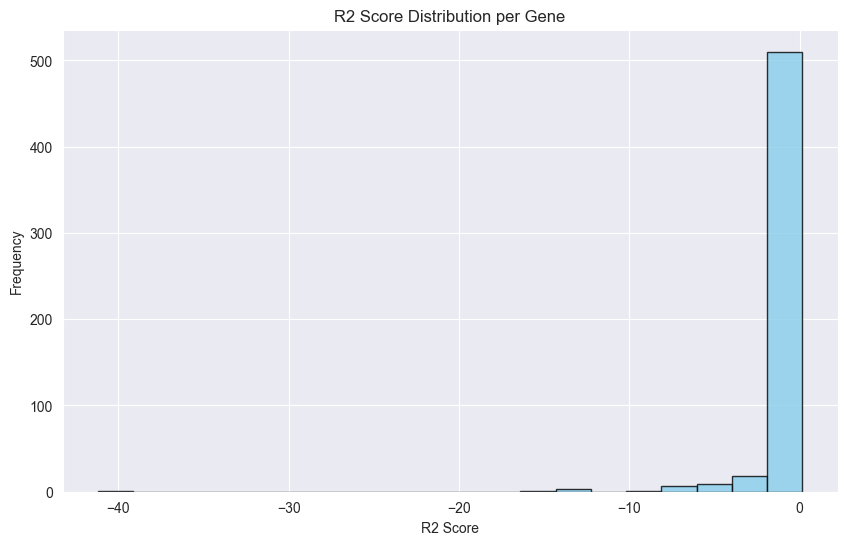

        gene   r2_score
292   Ckap2l   0.158102
461    Chrm3   0.151219
438  Igfbpl1   0.105527
281   Necab1   0.100605
436   Rwdd2a   0.073576
..       ...        ...
363     Nfix -12.962582
173      Mog -13.462359
286     Cftr -13.708734
137    Sox10 -14.832319
86     Sulf2 -41.217540

[550 rows x 2 columns]


In [18]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.figure(figsize=(10,6))
plt.hist(preds_test_per_gene['r2_score'], bins=20, alpha=0.8, color='skyblue', edgecolor='black')
plt.title('R2 Score Distribution per Gene')
plt.xlabel('R2 Score')
plt.ylabel('Frequency')
plt.show()

# Sorting by r2_score
preds_test_per_gene = preds_test_per_gene.sort_values(by='r2_score', ascending=False)

# Display the sorted DataFrame
print(preds_test_per_gene)


,gene,r2_score
292,Ckap2l,0.158102
461,Chrm3,0.151219
438,Igfbpl1,0.105527
281,Necab1,0.100605
436,Rwdd2a,0.073576
...,...,...
363,Nfix,-12.962582
173,Mog,-13.462359
286,Cftr,-13.708734
137,Sox10,-14.832319


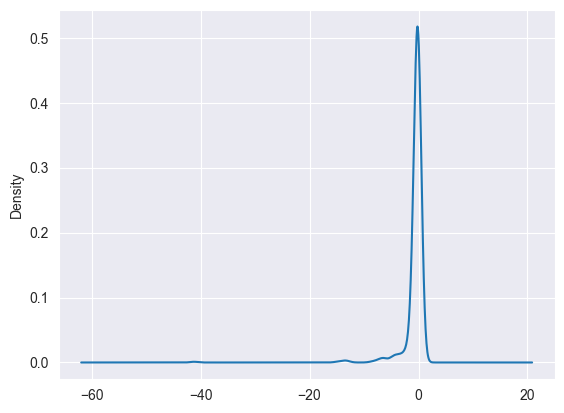

In [19]:
preds_test_per_gene

# plot r2 score distribution per gene, histogram
# density plot
preds_test_per_gene.r2_score.plot.kde()
#preds_test_per_gene.r2_score.plot.hist(bins=20, alpha=0.8)

# plot r2 score distribution per celltype, histogram
#preds_test_per_cell.r2_score.plot.hist(bins=10, alpha=0.8)

# sort by r2 score
preds_test_per_gene.sort_values(by='r2_score', ascending=False, inplace=True)
preds_test_per_gene

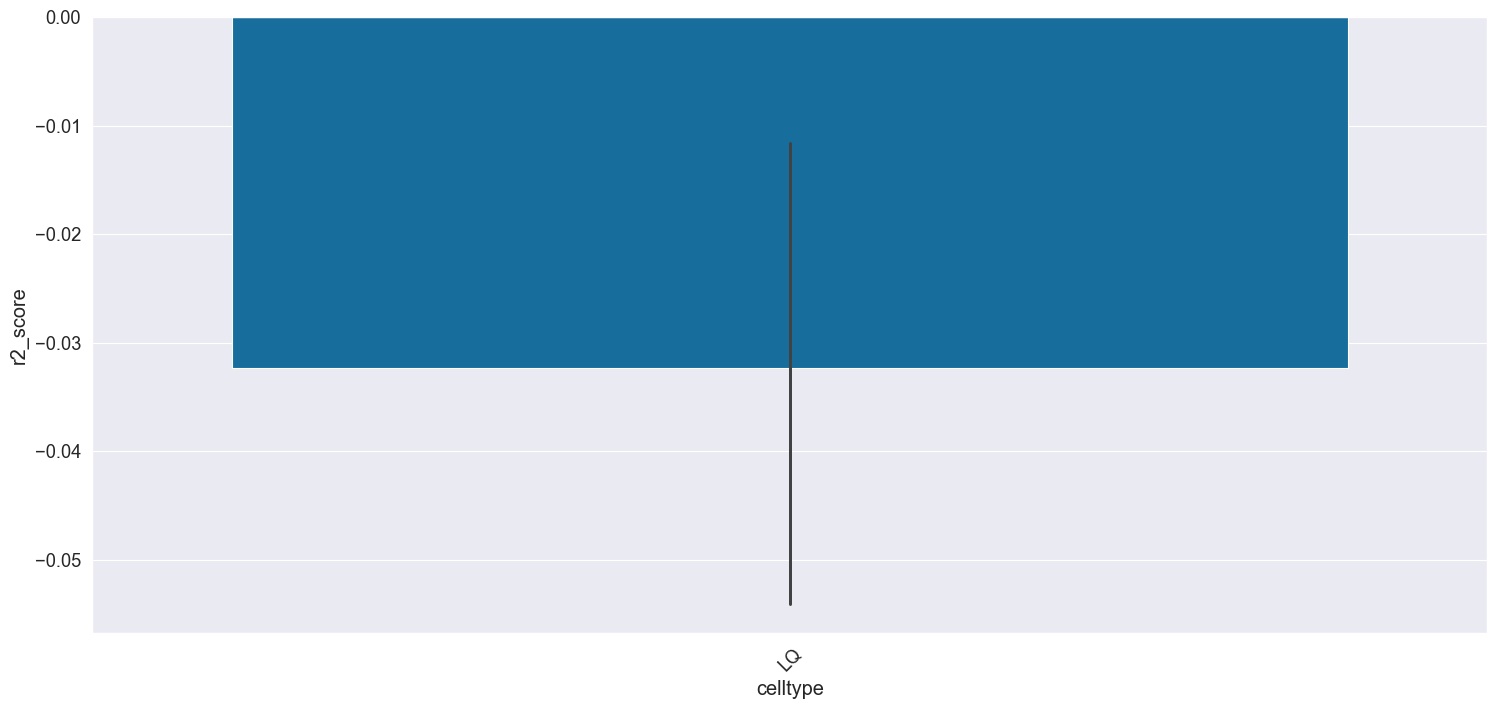

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# set style
sns.set_palette("colorblind")
sns.set_context("paper", font_scale=1.5)

# make plot larger
plt.figure(figsize=(18,8))

# rotate x-axis labels
plt.xticks(rotation=45)

# create plot of mean R2 score per celltype
# order bars by mean R2 score

# add avlue counts from adata.obs.class_label.value_counts()
ax = sns.barplot(x="celltype", y="r2_score", data=preds_test_per_cell, order=preds_test_per_cell.groupby('celltype').mean().sort_values(by='r2_score', ascending=False).index)

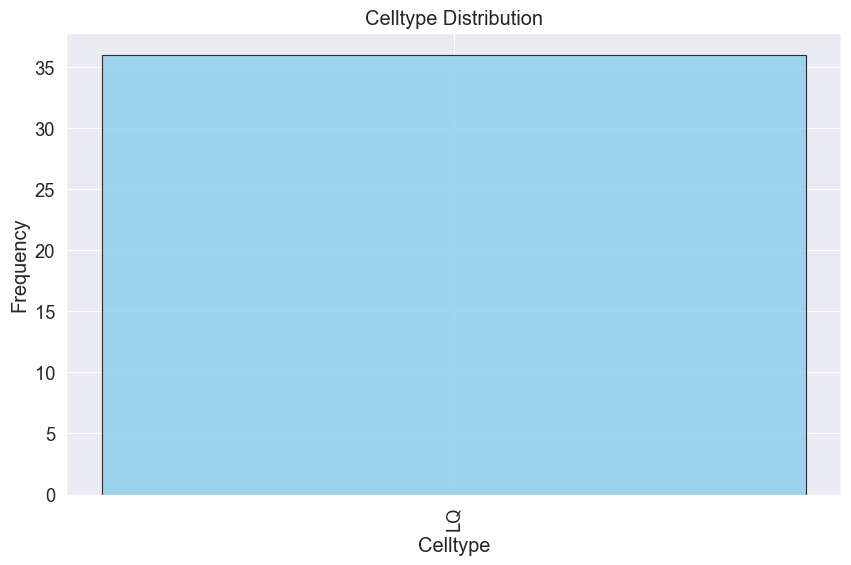

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the frequency of each celltype
celltype_counts = preds_test_per_cell['celltype'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.bar(celltype_counts.index, celltype_counts.values, alpha=0.8, color='skyblue', edgecolor='black')
plt.xticks(rotation='vertical')
plt.xticks(rotation=90)
plt.title('Celltype Distribution')
plt.xlabel('Celltype')
plt.ylabel('Frequency')
plt.show()


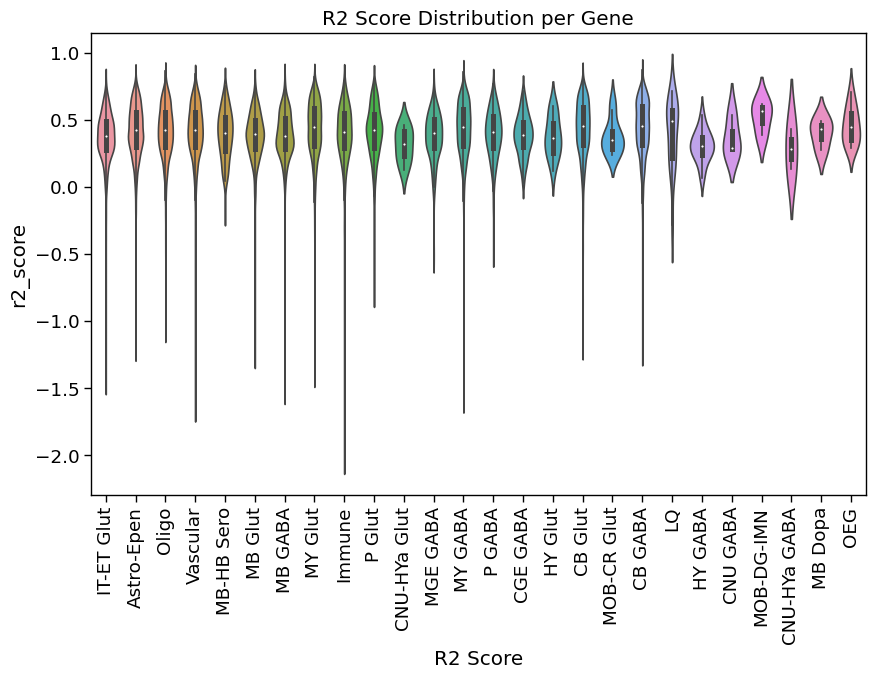

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.violinplot(x="celltype", y="r2_score", data=preds_test_per_cell)
# rotate x-axis labels
plt.xticks(rotation=90)
plt.title('R2 Score Distribution per Gene')
plt.xlabel('R2 Score')
plt.show()


In [3]:
file_path = "./data/subset_6img_atlas_brain.h5ad"
root_path = "./data"
dataset = InMemoryGraphDataset(root= root_path,
                               data_names = "data_test",
                               file_path=file_path, image_col="section", label_col="class_label", include_label=False, radius=20,node_level = 1, batch_size=1)



Processing...


KeyboardInterrupt: 

In [3]:
# Load your dataset
import torch
data = torch.load('./data/data_test.pt')